## yt frb's with shapely/PIL masks!


This notebook was inspired by Maxime Trebitsch's great lightning talk explaining how this image was created https://twitter.com/maximetrebitsch/status/1227622442681733120

I decided to attempt to make some composite images purely in python by manipulating fixed resolution buffers from yt with pillow. 

The steps in this notebook include:

* extracting a fixed resolution buffers (FRBs) of two fields
* initializing pillow `Image` arrays from color-mapped FRBs
* applying pillow mask layers to make a composite figure 
* using shapely to generate a rotating mask

In [1]:
import yt
ds = yt.load("IsolatedGalaxy/galaxy0030/galaxy0030")

yt : [INFO     ] 2020-12-10 14:55:43,473 Parameters: current_time              = 0.0060000200028298
yt : [INFO     ] 2020-12-10 14:55:43,473 Parameters: domain_dimensions         = [32 32 32]
yt : [INFO     ] 2020-12-10 14:55:43,474 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2020-12-10 14:55:43,474 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2020-12-10 14:55:43,474 Parameters: cosmological_simulation   = 0.0


In [2]:
sl = ds.slice(2, 0.5)
frb = sl.to_frb((10,'kpc'),(500,500))

In [3]:
import numpy as np
dens = np.array(frb["density"])
print(dens.shape)
print((dens.min(),dens.max()))

yt : [INFO     ] 2020-12-10 14:55:45,060 Making a fixed resolution buffer of (density) 500 by 500
Parsing Hierarchy : 100%|██████████| 173/173 [00:00<00:00, 13734.38it/s]
yt : [INFO     ] 2020-12-10 14:55:45,082 Gathering a field list (this may take a moment.)


(500, 500)
(7.837912002211197e-28, 7.722592404469927e-24)


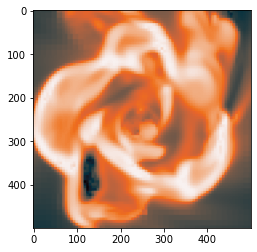

In [4]:
import matplotlib.pyplot as plt 
plt.imshow(np.log10(dens),cmap='dusk')

yt : [INFO     ] 2020-12-10 14:55:49,395 Making a fixed resolution buffer of (temperature) 500 by 500


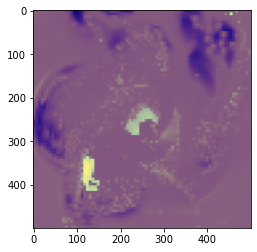

In [5]:
plt.imshow(np.log10(np.array(frb["temperature"])),cmap='kelp')

In [6]:
# create some image arrays: 
from PIL import Image
from matplotlib import cm
from matplotlib.colors import Normalize

def rgb_from_data(data, cmap = 'dusk', vmin = None, vmax = None):
    
    cmap_instance = cm.get_cmap(cmap)
            
    if vmin is None:
        vmin = data.min() 
    if vmax is None:
        vmax = data.max()         
        
    norm = Normalize(vmin=vmin, vmax=vmax)    
    return Image.fromarray(np.uint8(cmap_instance(norm(data))*255))


im_layers = [
    rgb_from_data(np.log10(np.array(frb['density'])),cmap='dusk'),
    rgb_from_data(np.log10(np.array(frb['temperature'])),cmap='kelp'),    
]


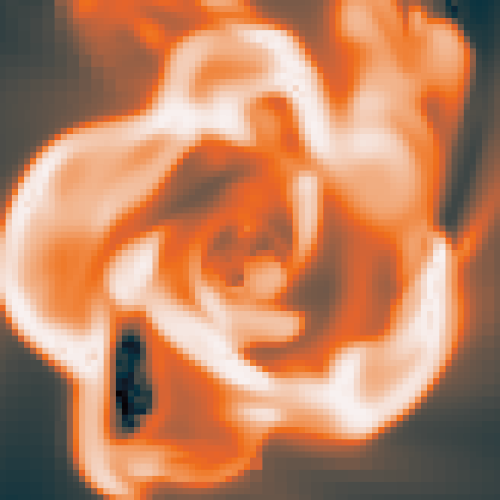

In [7]:
im_layers[0]

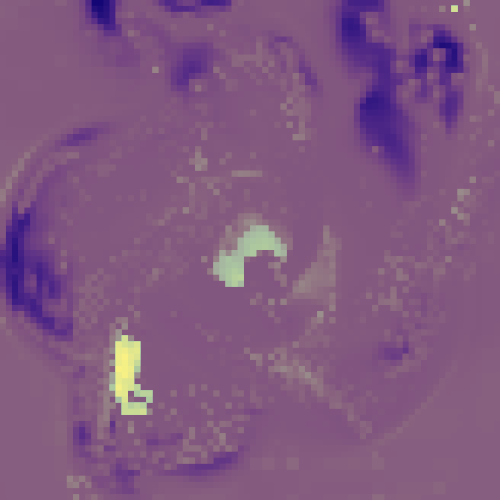

In [8]:
im_layers[1]

In [9]:
# let's blend them! https://note.nkmk.me/en/python-pillow-composite/

In [10]:
from PIL import ImageDraw, ImageFilter

In [11]:
alpha_value = 128
mode = "L" # see https://pillow.readthedocs.io/en/stable/handbook/concepts.html#modes 
mask = Image.new(mode, im_layers[0].size, alpha_value)

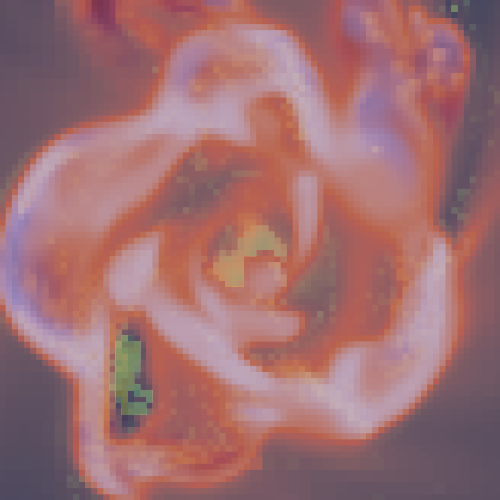

In [12]:
im_combo = Image.composite(im_layers[0], im_layers[1], mask)
im_combo

In [16]:
im_list = []
for alpha_value in range(0,255,5):
    mask = Image.new(mode, im_layers[0].size, alpha_value)    
    im_list.append(Image.composite(im_layers[0], im_layers[1], mask))
    
for alpha_value in range(255,-1,-5):
    mask = Image.new(mode, im_layers[0].size, alpha_value)    
    im_list.append(Image.composite(im_layers[0], im_layers[1], mask))
    
im_list[0].save('resources/PILfade_den_to_temp.gif',save_all=True,append_images=im_list[1:],duration=20,loop=0)
    

![fade out](https://i.imgur.com/WgLhOHj.gif)

In [17]:
# PIL has some geometric drawing, but shapely is more intuitive to me... 
# and it'll be fun to link the two packages... 
# so let's create a PIL mask by rotating a shapely box
from shapely import affinity # for rotations
from shapely.geometry import Point, box 

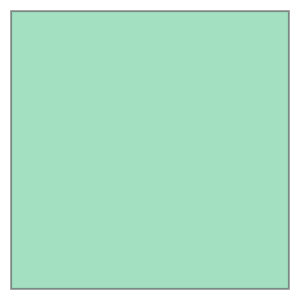

In [18]:
# our image
b = box(0,0,500,500)
b

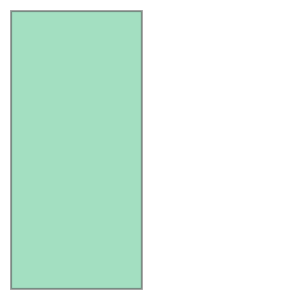

In [25]:
# make a box that will cover half the domain
# make sure it extends beyond the domain thru rotation
b2 = box(250,-200,650,650)
b2

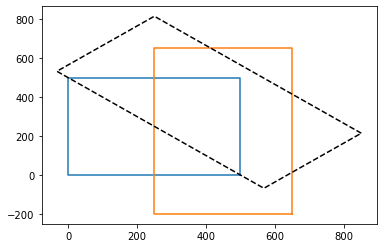

In [24]:
# quick check on our shapes, with a rotation of our 
# masking box 
import matplotlib.pyplot as plt

x,y = b.exterior.xy
plt.plot(x,y)

x,y = b2.exterior.xy
plt.plot(x,y)

b_r = affinity.rotate(b2, 45,origin = Point(250,250))
x,y = b_r.exterior.xy
plt.plot(x,y,'--k')

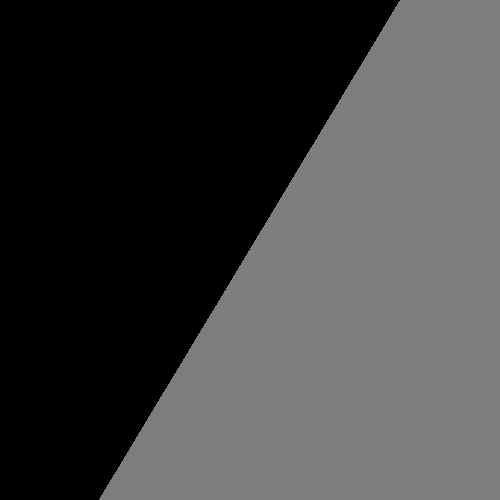

In [27]:
# to use the shapely polygon to draw a mask:

# init the mask 
mask = Image.new(mode, im_layers[0].size, alpha_value) 

# rotate our polygon, pull out exterior points 
b2 = affinity.rotate(b2, 30, origin = Point(250,250))
xy = list(zip(b2.exterior.xy[0],b2.exterior.xy[1]))

# use draw.polygon to draw our rotated polygon
draw = ImageDraw.Draw(mask)
draw.polygon(xy,fill=125)

mask

In [28]:
# ok, now rotate and save images. add a gaussian blur for fun!
b2 = box(250,-200,650,650)

im_list = []
for rotate_iters in range(0,360):
    mask = Image.new(mode, im_layers[0].size, alpha_value)    
    
    b2 = affinity.rotate(b2, 1, origin = Point(250,250))
    xy = list(zip(b2.exterior.xy[0],b2.exterior.xy[1]))
    
    draw = ImageDraw.Draw(mask)
    draw.polygon(xy,fill=255)

    mask = mask.filter(ImageFilter.GaussianBlur(radius=10))
    im_list.append(Image.composite(im_layers[0], im_layers[1], mask))
    
im_list[0].save('resources/PILrotate_den_to_temp.gif',save_all=True,append_images=im_list[1:],duration=10,loop=0)
    

![Rotation](https://i.imgur.com/apC0LYC.gif)